In [3]:
# Loading Libraries
import pandas as pd
import sklearn as sk
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import log_hyperu as hyperu

In [37]:
# Simulate Data
torch.manual_seed(1234)  # For reproducibility

## Data Set 1 - Basic Coefficients - Normal Sample Size
variables = 4
sample = 100
true_coefs = torch.tensor([[0.5],[0.2],[5.3],[4.2]])
X = torch.randn(sample, variables)
Y = X @ true_coefs + torch.randn(sample, 1) * 0.1 

# Basic OLS Estimate
beta_OLS = torch.linalg.lstsq(X, Y).solution
print(beta_OLS)


tensor([[0.4938],
        [0.1951],
        [5.2891],
        [4.2099]])


In [104]:
## LASSO Implementation
class LassoRegression(nn.Module):
    def __init__(self, num_features):
        super(LassoRegression, self).__init__()
        self.linear = nn.Linear(variables, 1) 
        self.l1_penalty = nn.L1Loss(reduction='sum')

    def forward(self, x):
        return self.linear(x)

def lasso_regression(X, y, lambda_l1, num_epochs=1000, lr=0.01):
    # Initialize the model
    model = LassoRegression(X.shape[1])

    # Define optimizer
    optimizer = optim.SGD(model.parameters(), lr=lr)

    # Training loop
    for epoch in range(num_epochs):
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(X)
        
        # Compute L1 regularization term
        l1_reg = torch.tensor(0., requires_grad=True)
        for param in model.parameters():
            l1_reg = l1_reg + torch.norm(param, 1)

        # Compute loss
        loss = nn.MSELoss()(outputs, y) + lambda_l1 * l1_reg

        # Backward pass
        loss.backward()
        
        # Update parameters
        optimizer.step()

        if (epoch+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

    # Return the trained model
    return model

trained_model = lasso_regression(X, Y, 4)
coefficients = trained_model.linear.weight.detach().numpy()
intercept = trained_model.linear.bias.item()

print("Coefficients:", coefficients)
print("Intercept:", intercept)


Epoch [100/1000], Loss: 30.822105407714844
Epoch [200/1000], Loss: 30.587779998779297
Epoch [300/1000], Loss: 30.495723724365234
Epoch [400/1000], Loss: 30.590938568115234
Epoch [500/1000], Loss: 30.5347900390625
Epoch [600/1000], Loss: 30.57209014892578
Epoch [700/1000], Loss: 30.573200225830078
Epoch [800/1000], Loss: 30.569324493408203
Epoch [900/1000], Loss: 30.54937744140625
Epoch [1000/1000], Loss: 30.59555435180664
Coefficients: [[-0.01088759 -0.01968116  3.194002    2.367281  ]]
Intercept: 0.007841205224394798


In [133]:
# Triple-Gamma-Regularization

class CustomRegularizationModel(nn.Module):
    def __init__(self, num_features):
        super(CustomRegularizationModel, self).__init__()
        self.linear = nn.Linear(variables, 1)

    def forward(self, x):
        return self.linear(x)

def custom_regularization_loss(outputs, targets, coefficients, penalty, a, c, kappa):
    phi = (2*c)/((kappa**2)*a)
    # Squared loss
    squared_loss = nn.MSELoss()(outputs, targets)
    
    # Penalty term
    penalty_term = penalty * torch.norm(coefficients, p=1)
    
    penalty_loss = 0
    for coefs in coefficients[0]:
        beta = torch.tensor([[coefs.item()]])
        loss_individual = hyperu.log_hyperu(torch.tensor([[c+0.5]]),torch.tensor([[1.5-a]]),(beta**2)/(2*phi))
        penalty_loss = penalty_loss + loss_individual
    
    torch.sum()
    # Combined loss
    loss = squared_loss - penalty_loss
    
    return loss

def train_model_with_regularization(X, y, penalty, a, c, kappa, num_epochs=1000, lr=0.01):
    model = CustomRegularizationModel(X.shape[1])
    optimizer = optim.SGD(model.parameters(), lr=lr)
    coef_list = list()
    loss_list = list()

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs = model(X)
        loss = custom_regularization_loss(outputs, y, model.linear.weight, penalty, a, c, kappa)
        loss.backward()
        coef_list.append(model.linear.weight)
        loss_list.append(loss)
        #Gradient Clipping???
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        if (epoch+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

    return model, coef_list, loss_list


trained_model2, coefs, loss_of_optimization = train_model_with_regularization(X, Y, 4, 0.1, 0.1, 2) # Covariates, Targets, Penalty, a, c, kappa
coefficients = trained_model2.linear.weight.detach().numpy()
intercept = trained_model2.linear.bias.item()

print("Coefficients General Function:", coefficients)
print("Intercept General Function:", intercept)

Epoch [100/1000], Loss: 22.174278259277344
Epoch [200/1000], Loss: 15.898294448852539
Epoch [300/1000], Loss: 10.110371589660645
Epoch [400/1000], Loss: 5.783623695373535
Epoch [500/1000], Loss: 2.975903034210205
Epoch [600/1000], Loss: 0.6392889618873596
Epoch [700/1000], Loss: 1.0254143476486206
Epoch [800/1000], Loss: 1.3963236808776855
Epoch [900/1000], Loss: 1.482465386390686
Epoch [1000/1000], Loss: 1.5052837133407593
Coefficients General Function: [[0.49391526 0.19265243 5.286164   4.209147  ]]
Intercept General Function: -0.005976935848593712


In [88]:
Custom Loss Test
print(coefficients)
a = torch.tensor([[0.5]])
b = torch.tensor([[0.5]])
c = torch.tensor([[0.5]])
custom_loss = 0

for coefs in coefficients[0]:
    beta = torch.tensor([[coefs]])
    loss_individual = hyperu.log_hyperu(a,b,beta**2)
    print(loss_individual)
    custom_loss = custom_loss + loss_individual

print(custom_loss)
#print(hyperu.log_hyperu(a,b,c))

[[-0.02184849  0.01860901  3.1137912   2.3287895 ]]
tensor([[0.5479]])
tensor([[0.5515]])
tensor([[-1.1820]])
tensor([[-0.9224]])
tensor([[-1.0050]])


In [123]:
a = 0.1
c = 0.1
kappa = 2
phi = (2*c)/((kappa**2)*a)
coef = torch.tensor([[4]])

hyperu.log_hyperu(torch.tensor([[c+0.5]]),torch.tensor([[1.5-a]]),(coef**2)/(2*phi))

tensor([[-1.6707]])

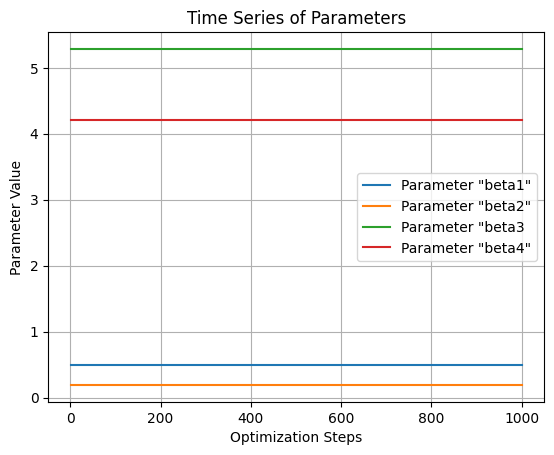

In [135]:
### Sample Plot
import matplotlib.pyplot as plt
beta1s = [tensor[0, 0].item() for tensor in coefs]
beta2s = [tensor[0, 1].item() for tensor in coefs]
beta3s = [tensor[0, 2].item() for tensor in coefs]
beta4s = [tensor[0, 3].item() for tensor in coefs]
optimization_steps = list(range(1, len(coefs) + 1))

plt.plot(optimization_steps, beta1s, label='Parameter "beta1"')
plt.plot(optimization_steps, beta2s, label='Parameter "beta2"')
plt.plot(optimization_steps, beta3s, label='Parameter "beta3')
plt.plot(optimization_steps, beta4s, label='Parameter "beta4"')
plt.xlabel('Optimization Steps')
plt.ylabel('Parameter Value')
plt.title('Time Series of Parameters')
plt.legend()
plt.grid(True)
plt.show()


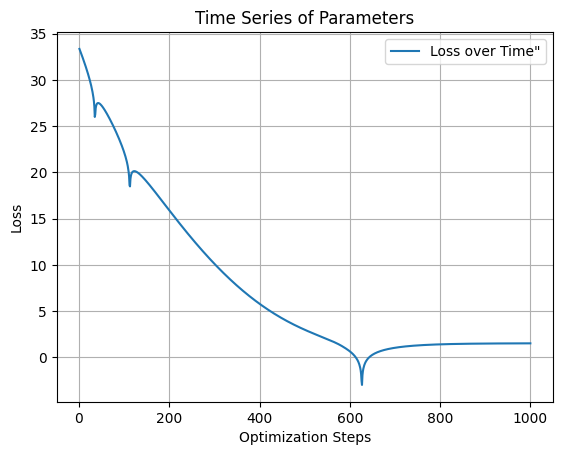

In [139]:
### Sample Plot

optimization_steps = list(range(1, len(loss_of_optimization) + 1))

plt.plot(optimization_steps, [loss[[0]].item() for loss in loss_of_optimization], label='Loss over Time"')
plt.xlabel('Optimization Steps')
plt.ylabel('Loss')
plt.title('Time Series of Parameters')
plt.legend()
plt.grid(True)
plt.show()


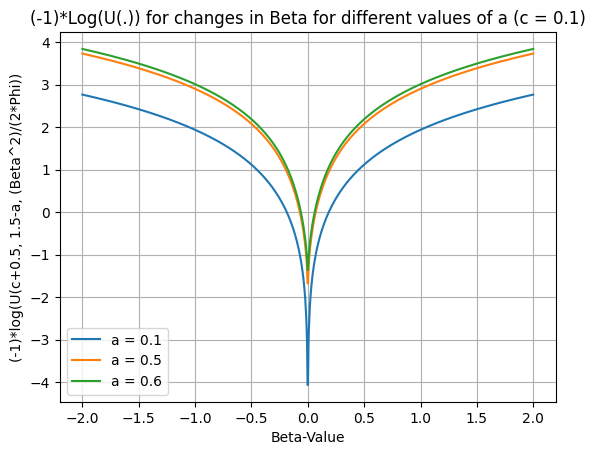

In [35]:
### Effect of Changes in a on Regularization

# Define the values for x
x_values = np.linspace(-2, 2, 1000)  # Adjust the range and number of points as needed

# Define the values for parameter a
a_values = [0.1, 0.5, 0.6]

# Plot the function U(x, a) for each value of a
c = 0.1
for a in a_values:
    y_values = list()
    for x in x_values:
        phi = (2*c)/((kappa**2)*a)
        y_value = (-1)*hyperu.log_hyperu(torch.tensor([[c+0.5]]),torch.tensor([[1.5-a]]),(torch.tensor([[x]])**2)/(2*phi))
        y_values.append(y_value.item())
    plt.plot(x_values, y_values, label=f'a = {a}')

# Add labels and title
plt.xlabel('Beta-Value')
plt.ylabel('(-1)*log(U(c+0.5, 1.5-a, (Beta^2)/(2*Phi))')
plt.title('(-1)*Log(U(.)) for changes in Beta for different values of a (c = 0.1)')
plt.legend()
plt.grid(True)
plt.show()

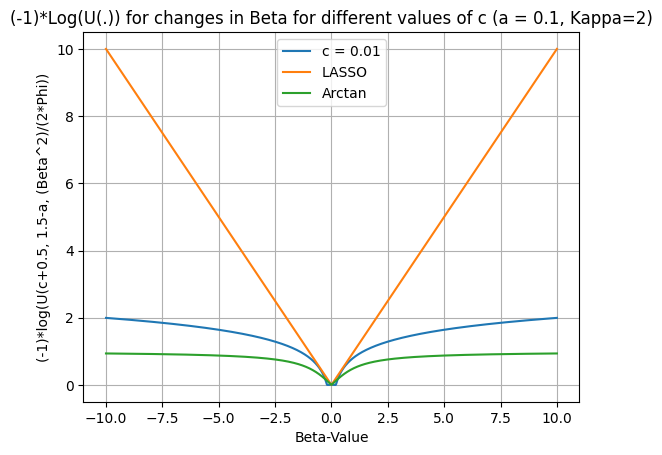

In [33]:
### Effect of Changes in c on Regularization

# Define the values for x
x_values = np.linspace(-10, 10, 1000)  # Adjust the range and number of points as needed

# Define the values for parameter a
c_values = [0.01]
lambda_values = [1]

# Plot the function U(x, a) for each value of a
a = 0.01
for c in c_values:
    for lamda in lambda_values:
        y_values = list()
        lasso_values = list()
        arctan_values = list()
        for x in x_values:
            kappa = 10
            phi = (2*c)/((kappa**2)*a)
            y_value = lamda*(-1)*0.5*hyperu.log_hyperu(torch.tensor([[c+0.5]]),torch.tensor([[1.5-a]]),(torch.tensor([[x]])**2)/(2*phi))
            lasso_values.append(lamda*abs(x))
            if (y_value.item() < 0):
                y_value = torch.tensor([[0]])
            arctan_values.append(lamda*(2/np.pi)*np.arctan(abs(x)))
            y_values.append(y_value.item())
        plt.plot(x_values, y_values, label=f'c = {c}')
plt.plot(x_values, lasso_values, label=f'LASSO')
plt.plot(x_values, arctan_values, label=f'Arctan')

# Add labels and title
plt.xlabel('Beta-Value')
plt.ylabel('(-1)*log(U(c+0.5, 1.5-a, (Beta^2)/(2*Phi))')
plt.title('(-1)*Log(U(.)) for changes in Beta for different values of c (a = 0.1, Kappa=2)')
plt.legend()
axes = plt.gca()
#axes.set_ylim([0,2])
plt.grid(True)
plt.show()

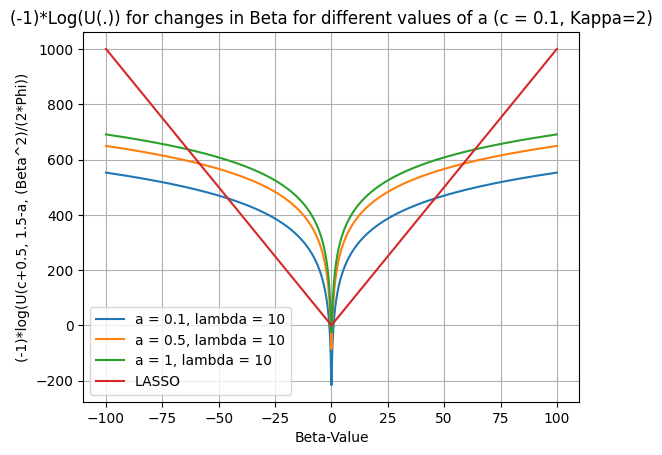

In [227]:
### Effect of Changes in a on Regularization

# Define the values for x
x_values = np.linspace(-100, 100, 1000)  # Adjust the range and number of points as needed

# Define the values for parameter a
a_values = [0.1,0.5,1]
lambda_values = [10]

# Plot the function U(x, a) for each value of a
c = 0.1
for a in a_values:
    for lamda in lambda_values:
        y_values = list()
        lasso_values = list()
        for x in x_values:
            kappa = 2
            phi = (2*c)/((kappa**2)*a)
            y_value = lamda*(-1)*hyperu.log_hyperu(torch.tensor([[c+0.5]]),torch.tensor([[1.5-a]]),(torch.tensor([[x]])**2)/(2*phi))*10
            lasso_values.append(lamda*abs(x))
            y_values.append(y_value.item())
        plt.plot(x_values, y_values, label=f'a = {a}, lambda = {lamda}')
plt.plot(x_values, lasso_values, label=f'LASSO')

# Add labels and title
plt.xlabel('Beta-Value')
plt.ylabel('(-1)*log(U(c+0.5, 1.5-a, (Beta^2)/(2*Phi))')
plt.title('(-1)*Log(U(.)) for changes in Beta for different values of a (c = 0.1, Kappa=2)')
plt.legend()
plt.grid(True)
plt.show()

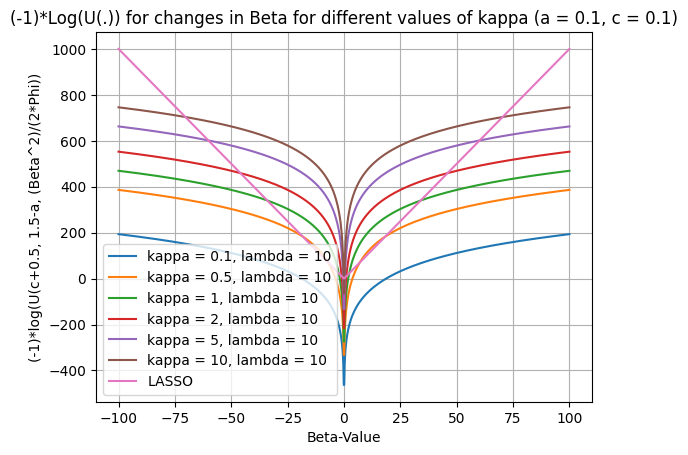

In [231]:
### Effect of Changes in kappa on Regularization

# Define the values for x
x_values = np.linspace(-100, 100, 1000)  # Adjust the range and number of points as needed

# Define the values for parameter a
kappa_values = [0.1,0.5,1,2, 5, 10]
lambda_values = [10]

# Plot the function U(x, a) for each value of a
a = 0.1
c = 0.1
for kappa in kappa_values:
    for lamda in lambda_values:
        y_values = list()
        lasso_values = list()
        for x in x_values:
            phi = (2*c)/((kappa**2)*a)
            y_value = lamda*(-1)*hyperu.log_hyperu(torch.tensor([[c+0.5]]),torch.tensor([[1.5-a]]),(torch.tensor([[x]])**2)/(2*phi))*10
            lasso_values.append(lamda*abs(x))
            y_values.append(y_value.item())
        plt.plot(x_values, y_values, label=f'kappa = {kappa}, lambda = {lamda}')
plt.plot(x_values, lasso_values, label=f'LASSO')

# Add labels and title
plt.xlabel('Beta-Value')
plt.ylabel('(-1)*log(U(c+0.5, 1.5-a, (Beta^2)/(2*Phi))')
plt.title('(-1)*Log(U(.)) for changes in Beta for different values of kappa (a = 0.1, c = 0.1)')
plt.legend()
plt.grid(True)
plt.show()

In [38]:
# Triple-Gamma-Regularization

class CustomRegularizationModel(nn.Module):
    def __init__(self, num_features):
        super(CustomRegularizationModel, self).__init__()
        self.linear = nn.Linear(variables, 1)

    def forward(self, x):
        return self.linear(x)

def custom_regularization_loss(outputs, targets, coefficients, penalty, a, c, kappa):
    phi = (2*c)/((kappa**2)*a)
    # Compute the squared loss
    squared_loss = nn.MSELoss()(outputs, targets)
    
    # Compute the penalty term        
    penalty_term = torch.sum(hyperu.log_hyperu(torch.tensor([[c+0.5]]),torch.tensor([[1.5-a]]),(coefficients**2)/(2*phi)))
    
    # Compute sum of squared loss and penalty
    total_loss = squared_loss - penalty_loss
    
    return total_loss

def train_model_with_regularization(X, y, penalty, a, c, kappa, num_epochs=1000, lr=0.01):
    model = CustomRegularizationModel(X.shape[1])
    optimizer = optim.SGD(model.parameters(), lr=lr)
    coef_list = list()
    loss_list = list()

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs = model(X)
        loss = custom_regularization_loss(outputs, y, model.linear.weight, penalty, a, c, kappa)
        loss.backward()
        coef_list.append(model.linear.weight)
        loss_list.append(loss)
        #Gradient Clipping???
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        if (epoch+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

    return model, coef_list, loss_list


trained_model2, coefs, loss_of_optimization = train_model_with_regularization(X, Y, 4, 0.1, 0.1, 2) # Covariates, Targets, Penalty, a, c, kappa
coefficients = trained_model2.linear.weight.detach().numpy()
intercept = trained_model2.linear.bias.item()

print("Coefficients General Function:", coefficients)
print("Intercept General Function:", intercept)

NameError: name 'penalty_loss' is not defined